In [7]:
import sys
import os
sys.path.append('../../')

%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.io import imread

from gen.load_data import load_data

In [3]:
from sklearn.utils import shuffle

train_df, valid_df, test_df = load_data('../../data')

train_df = shuffle(train_df)
valid_df = shuffle(valid_df)

print(train_df.head())


                                                  image                   id  \
102   ../../data/Train/CameraRGB/episode_0006_000107...  episode_0006_000107   
4472  ../../data/Train/CameraRGB/episode_0010_000127...  episode_0010_000127   
4283  ../../data/Train/CameraRGB/episode_0013_000290...  episode_0013_000290   
1022  ../../data/Train/CameraRGB/episode_0001_000146...  episode_0001_000146   
2037  ../../data/Train/CameraRGB/episode_0011_000149...  episode_0011_000149   

                                                  label  
102   ../../data/Train/CameraSeg/episode_0006_000107...  
4472  ../../data/Train/CameraSeg/episode_0010_000127...  
4283  ../../data/Train/CameraSeg/episode_0013_000290...  
1022  ../../data/Train/CameraSeg/episode_0001_000146...  
2037  ../../data/Train/CameraSeg/episode_0011_000149...  


In [5]:
from models.unet import model_unetVGG16

model = model_unetVGG16(3, image_shape=(384, 384, 3), keep_prob=0.5)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 384, 384, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 384, 384, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 192, 192, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [8]:
from gen.datagen import oversample_generator_from_df, balanced_generator_from_df

BATCH_SIZE = 32

model_dir = '../../saved_models/unet/unet_v2/'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

from skimage.io import imread
from gen.datagen import preprocess_label

weights = []
for _, row in train_df.iterrows():
    lbl = preprocess_label(imread(row['label']))
    xd, yd = lbl[:, :, 0].nonzero()
    if xd.shape[0] > 0 and yd.shape[0] > 0:
        weights.append( 1 + (xd.max() - xd.min()) * (yd.max() - yd.min()) )
    else:
        weights.append(1)

weights = np.array(weights)
weights = [float(i)/sum(weights) for i in weights]

train_gen = oversample_generator_from_df(train_df, BATCH_SIZE, (384, 384), weights)
valid_gen = balanced_generator_from_df(valid_df, BATCH_SIZE, (384, 384))


In [10]:
from train import euclidean_distance_loss
from keras.utils.training_utils import multi_gpu_model
from keras.optimizers import RMSprop, Adam

gpus = 2

model_gpu = multi_gpu_model(model, gpus)
ad = RMSprop(0.05)
model_gpu.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])


In [11]:
from train import train_nn

m = train_df.shape[0]
history = train_nn(model_gpu, 
                   train_gen, 
                   valid_gen, 
                   training_size=m, 
                   batch_size=BATCH_SIZE,
                   validation_size=valid_df.shape[0],
                   output_path=model_dir, 
                   epochs=100,
                  gpus = 2)

Instructions for updating:
Use the retry module or similar alternatives.
Epoch 1/100
75/75 [==============================] - 75s 995ms/step - loss: 0.5125 - acc: 0.7520 - val_loss: 0.2752 - val_acc: 0.9172

Epoch 00001: val_loss improved from inf to 0.27517, saving model to ../../saved_models/unet/unet_v2//model.hdf5
Epoch 2/100
75/75 [==============================] - 70s 929ms/step - loss: 0.1018 - acc: 0.9662 - val_loss: 0.1988 - val_acc: 0.9431

Epoch 00002: val_loss improved from 0.27517 to 0.19883, saving model to ../../saved_models/unet/unet_v2//model.hdf5
Epoch 3/100
75/75 [==============================] - 70s 934ms/step - loss: 0.3511 - acc: 0.9317 - val_loss: 0.6736 - val_acc: 0.7153

Epoch 00003: val_loss did not improve
Epoch 4/100
75/75 [==============================] - 71s 943ms/step - loss: 0.0892 - acc: 0.9705 - val_loss: 0.4037 - val_acc: 0.8806

Epoch 00004: val_loss did not improve
Epoch 5/100
75/75 [==============================] - 70s 931ms/step - loss: 0.0584 

KeyboardInterrupt: 

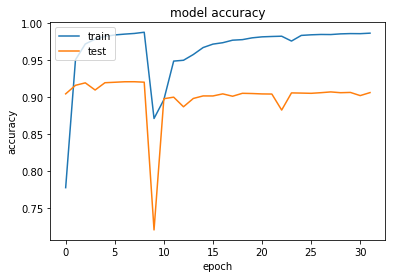

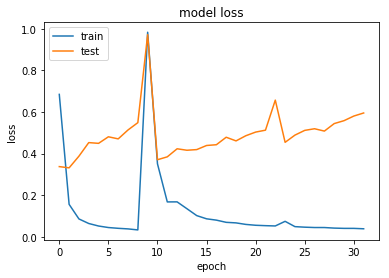

In [8]:
# # summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
model_gpu.load_weights('../../saved_models/unet/unet_v2/model.hdf5')
model.save('../../saved_models/unet/unet_v2/model_saved.h5')